# Runtime Optimization: Multiple Shots of algorithms on different Quantum Computers

Suppose we have to run a program on a Quantum Computer. It is from the nature of Quantum Computing to generate probabilistic results instead of deterministic ones. To this extent, there are differences on the expected output of each different machine available.

Thus, one question arises: how could we run the programs in different machines, with different probability of getting the correct result in the best possible time? Baeysian stats seems a potential candidate to facilitate this task.

As we are dealing with the Baeysian framework, we must choose a prior distribution over our desired parameter, $\theta_j$, the probability of getting the correct result in a single run in a given QC machine. In this case, we will use the uniform distribution. The other component, the likelihood, we will start considering simulated data on 4 different machines.

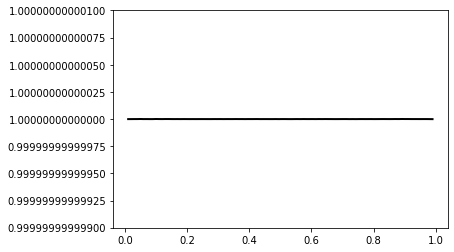

In [1]:
import math

from tqdm import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.optimize import minimize
from pymoo.factory import get_termination
import plotly.figure_factory as ff


mpl.rcParams['axes.formatter.useoffset'] = False

fig, ax = plt.subplots(1, 1)

a_prior, b_prior = 1,1

x = np.linspace(stats.beta.ppf(0.01, a_prior, b_prior),
                stats.beta.ppf(0.99, a_prior, b_prior), 100)
rv = stats.beta(a_prior, b_prior)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
 

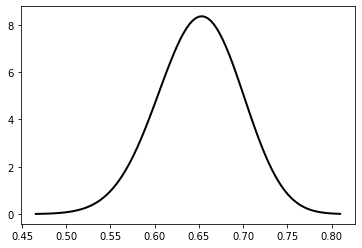

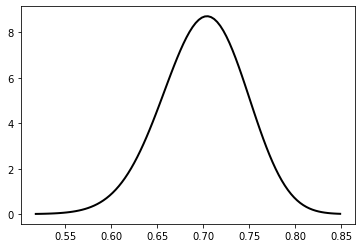

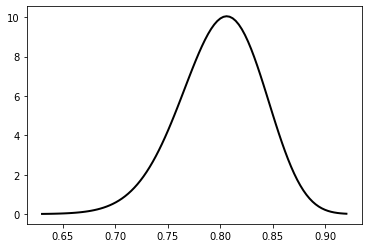

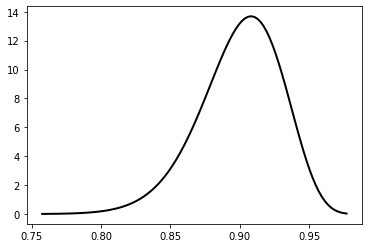

In [2]:
# data = [# success, # fails]

m1_data = [65, 35]
m2_data = [70, 30]
m3_data = [80, 20]
m4_data = [90, 10]

likelihood = [m1_data, m2_data, m3_data, m4_data]

mpl.rcParams['axes.formatter.useoffset'] = True

def plot_beta(a,b):
    
    fig, ax = plt.subplots(1, 1)

    x = np.linspace(stats.beta.ppf(0.0001, a, b),
                    stats.beta.ppf(0.9999, a, b), 100)
    rv = stats.beta(a, b)
    ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
    
for data in likelihood:
    plot_beta(data[0], data[1])


## Bayesian Statistics: way to update our belief based on new information

Bayesian Statistics is a powerful framework because it allow us to update our understanding of an underlying information as we gather more and more information about it. The classical Bayes Theorem \begin{equation}
P(\theta|\textbf{D}) = P(\theta ) \frac{P(\textbf{D} |\theta)}{P(\textbf{D})}
\end{equation} was developed more than 350 years ago and is the basis for many important tools statistician applied in diferent domains. Nevertheless, real world application can be chanllenging as it involves dealing with high dimensional integrals.

To this extent, a family of probability distributions make the application of the Baeysian framework much simpler, it's the conjugate family of distributions.

### Conjugacy
Conjugacy is a property where an updated probability distribution belongs to it's own family. For example, given a Beta distribution(a,b) and some observed data on successes and fails, the update version will also be a Beta distribution with different parameter values, Beta(a + #successes, b + #fails).


Thus, conjugacy presents itself as a desirable property to the problem in question as we can get an exact baeysian update to the fidelity of the machines without the need of dealing with the hurdles of multidimensional integrals.

/tmp/ipykernel_24858/34097274.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, rv.pdf(x), 'k-', lw=2, color=colors[i])
/tmp/ipykernel_24858/34097274.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, rv.pdf(x), 'k-', lw=2, color=colors[i])
/tmp/ipykernel_24858/34097274.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, rv.pdf(x), 'k-', lw=2, color=colors[i])
/tmp/ipykernel_24858/34097274.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, rv.pdf(x), 'k-', lw=2, color=colors[i])


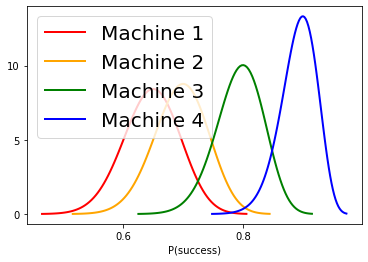

In [3]:
update_m1 = [m1_data[0] + a_prior, m1_data[1] + b_prior] 
update_m2 = [m2_data[0] + a_prior, m2_data[1] + b_prior] 
update_m3 = [m3_data[0] + a_prior, m3_data[1] + b_prior]
update_m4 = [m4_data[0] + a_prior, m4_data[1] + b_prior]

updates = [update_m1, update_m2, update_m3, update_m4]
colors=['red', 'orange', 'green', 'blue']
labels=[f"Machine {i}" for i in range(1,5)]

for i in range(0,len(updates)):
#     plot_beta(update[0], update[1])
    a,b = updates[i][0], updates[i][1]
    x = np.linspace(stats.beta.ppf(0.0001, a, b),
                    stats.beta.ppf(0.9999, a, b), 100)
    rv = stats.beta(a, b)
    plt.plot(x, rv.pdf(x), 'k-', lw=2, color=colors[i])
    

plt.xlabel("P(success)")
plt.rcParams['figure.figsize'] = [20, 10]
plt.legend(labels, loc=2, prop={'size': 20})
plt.rcParams.update({'font.size': 28})

In [4]:
# Calculate CV for each machine
def get_cv_from_beta_parameters(alpha, beta, return_snr=False):
#     mean = alpha/(alpha+beta)
#     variance = (alpha*beta)/((alpha+beta)**2*(alpha+beta+1))
    mean, variance = stats.beta.stats(alpha, beta, moments='mv')
    sd = math.sqrt(variance)    
    cv = sd/mean
    
    if return_snr:
        return(1/cv)
    
    return(cv)


## Signal-to-Noise ratio: a direct way to assess some probability distribution features

The Signal-to-noise ratio is a measure that allow us to simultaneously assess two critical features of a statistical distributions: the mean and the variance. Thus it allow us to depict the relation between the expected value of a random variable and the uncertainty around that value. It's equation is given by: \begin{equation}
\frac{\mu}{\sigma}\end{equation} where $\mu$ is the mean and $\sigma$ is the standard deviation. An important aspect of this quantity is that it allow for a straightforward way to compare different distributions by sintetizing information in two-dimensions based on a single number.

In the present case, it allows to understand which machines could have a better performance based on a higher signal-to-noise ratio.

In [44]:
snrs = [get_cv_from_beta_parameters(m[0], m[1], return_snr=True) for m in updates]
print(snrs)

# Generate data on expected queue time for each machine
queue_time_m1 = 1
queue_time_m2 = 2
queue_time_m3 = 3
queue_time_m4 = 5

queue_times = np.array([queue_time_m1, queue_time_m2, queue_time_m3, queue_time_m4])
snrs = np.array(snrs)

# Build proposed workload distribution scheme = f(SNR, expected_queue_time)
## explain it as a multiple-objective optimization

[13.741664139882525, 15.359141441058856, 19.932027350114545, 29.190596244182977]


## The problem

* Explain the issue with machines and queues
* Add picture showing machine, jobs and program allocation

## Multi-Objective Optmizaiton: how to optimize multiple function in a given optimaztion task


The Multi-Objective Optimization is an area o Optimaztion literature that deals with the challenge of optimization more than one functions simultaneously. This approach fits the problem being considered as is desirable to maximize the expected signal-to-noise ratio as  is to minimize the Expected Average Queue Time. To this extent it the problem we are dealing with could be formulated as follows:

\begin{equation}
\begin{gathered}
\max_{w} f_{1}(w, SNR)=\mathbb{E}[SNR]=\sum_{i=1}^{N}{SNR_{i}}*w_{i}\\
\min_{w} f_{2}(w, \lambda)=\mathbb{E}[Queue Time]=\sum_{i=1}^{N}{\lambda_{i}}*w_{i}\\
\textrm{s.t.} \sum_{i=1}^{N}w_{i}=1\\
    \min{w_{i}}=Minimal Allocation\\
    \mathbb{E}[Queue Time]=Max Run Time
\end{gathered}
\end{equation}

The last two restrictions are derived to give flexibility to the problem. It could be desirable to require a minimal allocation to each machine or to restrict the maximun acceptable amount of time for jobs conclusion.

In [45]:

class MyProblem(ElementwiseProblem):

    def __init__(self,*args,**kwargs):
        super().__init__(n_var=4,
                         n_obj=2,
                         n_constr=1,
                         xl=0,
                         xu=1)
        self.parameters=kwargs

    def _evaluate(self, x, out, *args, **kwargs):
        
        f1 = -(x @ self.parameters["snrs"])
        f2 = (x @ self.parameters["queue_times"])

        g1 = (sum(x)-1)**2-0.0001
        g2 = f2-self.parameters["max_run_time"]
        g3 = (min(x)-self.parameters["minimun_assign"])**2-0.0001

        out["F"] = [f1, f2]
        out["G"] = [g1, g2, g3]


problem = MyProblem(snrs=snrs, queue_times=queue_times, max_run_time=4, minimun_assign=0.00)


# Further development: We probably need to set a restriction in terms of a maximum amount of queue time.
## Parametrize to minimize the variance
## This would be more realistic since the total runtime is a function of max(queue_time)
# Further development: Minimize variance instead of maximizing SNR

## Optimization: Heuristic approach

- Briefly explain Heuristic approaches and Genetic Algorithms

In [46]:
algorithm = NSGA2(
    pop_size=50,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.8, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 1000)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |      50 |  0.003136435 |  3.001596736 |       1 |            - |            -
    2 |      60 |  0.003136435 |  1.905061641 |       1 |  0.00000E+00 |            f
    3 |      70 |  0.003136435 |  1.212704523 |       1 |  0.00000E+00 |            f
    4 |      80 |  0.003136435 |  0.681133357 |       1 |  0.00000E+00 |            f
    5 |      90 |  0.000470980 |  0.346636942 |       1 |  2.065640276 |        ideal
    6 |     100 |  0.000470980 |  0.192603254 |       1 |  0.00000E+00 |            f
    7 |     110 |  0.000470980 |  0.117243213 |       1 |  0.00000E+00 |            f
    8 |     120 |  0.000470980 |  0.078150403 |       1 |  0.00000E+00 |            f
    9 |     130 |  0.000470980 |  0.060438354 |       1 |  0.00000E+00 |            f
   10 |     140 |  0.000470980 |  0.045053231 |       1 |  0.00000E+00 |            f
   11 |     150 |  0.000470980 |  0.034206388 |       

  100 |    1040 |  0.00000E+00 |  0.00000E+00 |      50 |  4.39252E-06 |            f
  101 |    1050 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000050784 |            f
  102 |    1060 |  0.00000E+00 |  0.00000E+00 |      50 |  8.94631E-06 |            f
  103 |    1070 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000363720 |            f
  104 |    1080 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000124921 |            f
  105 |    1090 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  106 |    1100 |  0.00000E+00 |  0.00000E+00 |      50 |  0.017339494 |        ideal
  107 |    1110 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  108 |    1120 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  109 |    1130 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000064328 |            f
  110 |    1140 |  0.00000E+00 |  0.00000E+00 |      49 |  0.000082141 |            f
  111 |    1150 |  0.00000E+00 |  0.00000E+00 |      4

  226 |    2300 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  227 |    2310 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000034824 |            f
  228 |    2320 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000264829 |            f
  229 |    2330 |  0.00000E+00 |  0.00000E+00 |      50 |  6.10635E-06 |            f
  230 |    2340 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  231 |    2350 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  232 |    2360 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000069715 |            f
  233 |    2370 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  234 |    2380 |  0.00000E+00 |  0.00000E+00 |      50 |  5.97734E-06 |            f
  235 |    2390 |  0.00000E+00 |  0.00000E+00 |      50 |  0.004207489 |        nadir
  236 |    2400 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  237 |    2410 |  0.00000E+00 |  0.00000E+00 |      5

  339 |    3430 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  340 |    3440 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000104112 |            f
  341 |    3450 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  342 |    3460 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000103861 |            f
  343 |    3470 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000184078 |            f
  344 |    3480 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000024689 |            f
  345 |    3490 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000121675 |            f
  346 |    3500 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000071801 |            f
  347 |    3510 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000022560 |            f
  348 |    3520 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  349 |    3530 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  350 |    3540 |  0.00000E+00 |  0.00000E+00 |      5

  435 |    4390 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000044186 |            f
  436 |    4400 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  437 |    4410 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000130530 |            f
  438 |    4420 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  439 |    4430 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  440 |    4440 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000186797 |            f
  441 |    4450 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  442 |    4460 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000065886 |            f
  443 |    4470 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  444 |    4480 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000206489 |            f
  445 |    4490 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000204213 |            f
  446 |    4500 |  0.00000E+00 |  0.00000E+00 |      5

  532 |    5360 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  533 |    5370 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  534 |    5380 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000029885 |            f
  535 |    5390 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000063267 |            f
  536 |    5400 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  537 |    5410 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000096208 |            f
  538 |    5420 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000247996 |            f
  539 |    5430 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  540 |    5440 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  541 |    5450 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000032007 |            f
  542 |    5460 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  543 |    5470 |  0.00000E+00 |  0.00000E+00 |      5

  652 |    6560 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  653 |    6570 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000159738 |            f
  654 |    6580 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  655 |    6590 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000160285 |            f
  656 |    6600 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  657 |    6610 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  658 |    6620 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000314618 |            f
  659 |    6630 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000116333 |            f
  660 |    6640 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  661 |    6650 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  662 |    6660 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000027437 |            f
  663 |    6670 |  0.00000E+00 |  0.00000E+00 |      5

  761 |    7650 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  762 |    7660 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000375189 |            f
  763 |    7670 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  764 |    7680 |  0.00000E+00 |  0.00000E+00 |      50 |  6.93720E-07 |            f
  765 |    7690 |  0.00000E+00 |  0.00000E+00 |      50 |  3.38906E-06 |            f
  766 |    7700 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000265747 |            f
  767 |    7710 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000048387 |            f
  768 |    7720 |  0.00000E+00 |  0.00000E+00 |      50 |  0.004939442 |        ideal
  769 |    7730 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000233085 |            f
  770 |    7740 |  0.00000E+00 |  0.00000E+00 |      50 |  5.18948E-07 |            f
  771 |    7750 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000484087 |            f
  772 |    7760 |  0.00000E+00 |  0.00000E+00 |      5

  888 |    8920 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000066966 |            f
  889 |    8930 |  0.00000E+00 |  0.00000E+00 |      50 |  6.53409E-06 |            f
  890 |    8940 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000317231 |            f
  891 |    8950 |  0.00000E+00 |  0.00000E+00 |      50 |  0.00000E+00 |            f
  892 |    8960 |  0.00000E+00 |  0.00000E+00 |      50 |  4.67670E-06 |            f
  893 |    8970 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000224879 |            f
  894 |    8980 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000140843 |            f
  895 |    8990 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000081672 |            f
  896 |    9000 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000053633 |            f
  897 |    9010 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000258219 |            f
  898 |    9020 |  0.00000E+00 |  0.00000E+00 |      50 |  0.000139034 |            f
  899 |    9030 |  0.00000E+00 |  0.00000E+00 |      5

In [47]:
print(X)

[[9.79920329e-01 9.45317136e-03 1.94458239e-04 4.87205538e-04]
 [2.03924220e-01 9.63201821e-03 9.18518426e-02 6.98984858e-01]
 [7.10028386e-01 1.25492847e-02 5.24226063e-03 2.80953396e-01]
 [4.50293675e-01 4.08256535e-03 3.56428796e-06 5.35873193e-01]
 [7.10031235e-01 3.07852015e-02 2.00902057e-03 2.57017404e-01]
 [9.00165021e-01 9.68949879e-03 1.12872664e-03 9.85423063e-02]
 [8.80208613e-01 3.95299913e-03 6.61206305e-04 1.19389535e-01]
 [7.10028386e-01 1.25492847e-02 5.24226063e-03 2.73861437e-01]
 [8.01354020e-01 7.00500297e-03 2.02025388e-02 1.77487072e-01]
 [3.89765810e-01 3.17075382e-02 1.60022450e-04 5.81617986e-01]
 [9.18110402e-01 9.30577666e-03 1.12872664e-03 8.11827702e-02]
 [2.94203636e-01 1.91643971e-04 2.22331918e-06 7.11268910e-01]
 [7.99857748e-01 6.08854598e-03 2.99236277e-04 2.00227636e-01]
 [3.89765810e-01 3.17075382e-02 1.15847939e-03 5.87327960e-01]
 [7.75889383e-01 8.46516446e-03 3.56393784e-04 2.22201801e-01]
 [9.85091528e-01 8.75682255e-03 1.30368978e-04 1.502105

In [48]:
print(F)

[[-13.62902641   1.00184607]
 [-25.1847759    3.99366808]
 [-18.25540389   2.15562072]
 [-21.8930182    3.13783546]
 [-17.77238015   2.06271572]
 [-15.41759426   1.41564173]
 [-15.6544767    1.48704591]
 [-18.04838538   2.12016093]
 [-16.70315965   1.763407  ]
 [-22.82399678   3.36175088]
 [-15.15156481   1.34602199]
 [-24.80819894   3.85093815]
 [-16.93561982   1.81407073]
 [-23.01057562   3.39329613]
 [-17.28533568   1.9048979 ]
 [-14.11236615   1.07810153]
 [-23.13662305   3.48241912]
 [-17.53320341   1.96132675]
 [-17.09550009   1.86551606]
 [-23.96474886   3.67984126]
 [-24.81119252   3.92664369]
 [-22.37969856   3.23198357]
 [-23.57001946   3.61280412]
 [-23.74137652   3.64217935]
 [-14.73628992   1.30961131]
 [-23.45156552   3.54701707]
 [-16.3184593    1.65583559]
 [-24.16971382   3.70715805]
 [-25.02232847   3.96921786]
 [-24.53363642   3.79284319]
 [-16.04787793   1.60330536]
 [-22.08960185   3.17150777]
 [-14.34483881   1.18491314]
 [-24.36368193   3.74170738]
 [-14.9779222 

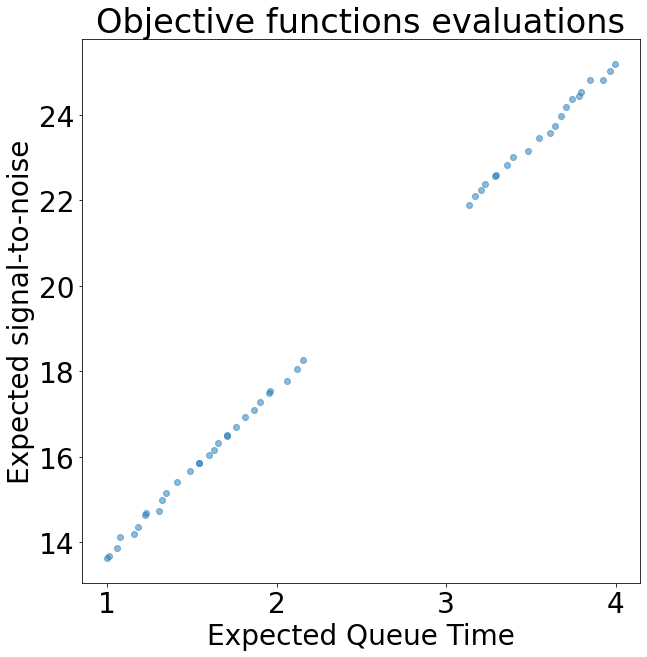

In [49]:
# Add plots for F and X
snr_sol = [-f[0] for f in F]
queue_time_sol = [f[1] for f in F]

plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(queue_time_sol, snr_sol, alpha=0.5)
plt.title("Objective functions evaluations")
plt.xlabel("Expected Queue Time")
plt.ylabel("Expected signal-to-noise")
plt.show()

In [11]:
# Compare proposed_distribution_runtime X run_time on even distribution 

# Explain that the exponential distribution could be used for decoherence time evaluation

In [40]:
del queue_time_sol

In [41]:
# Simulating data for machine time duration:

# PARAMETERS

N=50
MAX_RUN_TIME=4
MIN_ASSIGN = 0

QUEUE_TIME_M1 = 1
QUEUE_TIME_M2 = 2
QUEUE_TIME_M3 = 3
QUEUE_TIME_M4 = 5

np.random.seed(seed=4091989)


queue_times_1 = np.random.exponential(QUEUE_TIME_M1, N)
queue_times_2 = np.random.exponential(QUEUE_TIME_M2, N)
queue_times_3 = np.random.exponential(QUEUE_TIME_M3, N)
queue_times_4 = np.random.exponential(QUEUE_TIME_M4, N)

queues_times = zip(queue_times_1, queue_times_2, queue_times_3, queue_times_4)


for queue_simulation in tqdm(queues_times):
    
    problem = MyProblem(snrs=snrs,
                        queue_times=queue_simulation,
                        max_run_time=MAX_RUN_TIME,
                        minimun_assign=MIN_ASSIGN)
    algorithm = NSGA2(
    pop_size=50,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.8, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
    )

    termination = get_termination("n_gen", 1000)

    res = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=False,
                   verbose=False)

    X = res.X
    F = res.F
    snr=[-f[0] for f in F]
    queue_time = [f[1] for f in F]
    m1=[x[0] for x in X]
    m2=[x[1] for x in X]
    m3=[x[2] for x in X]
    m4=[x[3] for x in X]
    try:
        snr_totals_sol=np.append(snr_totals_sol, snr)
        queue_time_sol=np.append(queue_time_sol, queue_time)
        m1_total=np.append(m1_total, m1)
        m2_total=np.append(m2_total, m2)
        m3_total=np.append(m3_total, m3)
        m4_total=np.append(m4_total, m4)
    except:
        snr_totals_sol=snr
        queue_time_sol=queue_time
        m1_total=m1
        m2_total=m2
        m3_total=m3
        m4_total=m4
        


1000it [1:01:30,  3.69s/it]


/tmp/ipykernel_24858/1563615310.py:9: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.

/tmp/ipykernel_24858/1563615310.py:10: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.



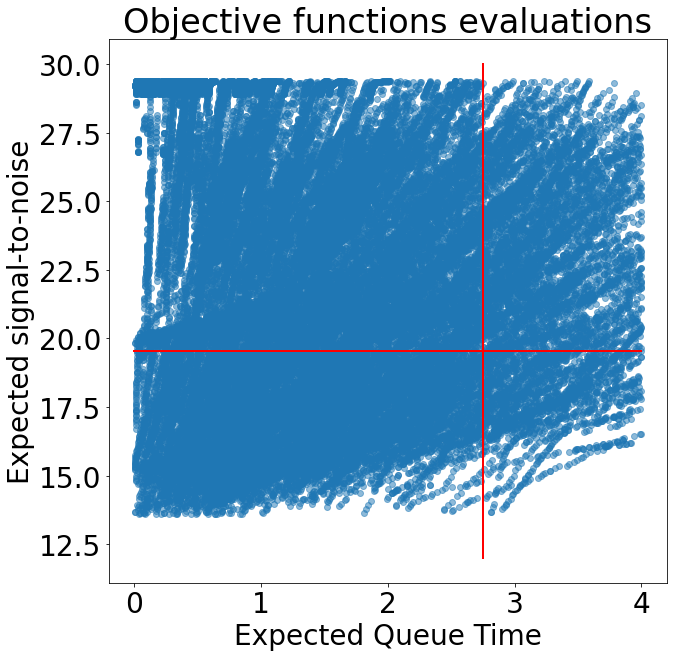

In [42]:
# Objective functions evaluation

plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(queue_time_sol, snr_totals_sol, alpha=0.5)
plt.title("Objective functions evaluations")
plt.xlabel("Expected Queue Time")
plt.ylabel("Expected signal-to-noise")
plt.rcParams.update({'font.size': 28})
plt.plot([2.75, 2.75], [12, 30], 'k-', lw=2, color="red")
plt.plot([0, 4], [19.56, 19.56], 'k-', lw=2, color="red")
plt.show()

In [43]:
# Even distributed benchmark

bench_snr=sum(snrs)/4
bench_queue_time=sum([QUEUE_TIME_M1,QUEUE_TIME_M2,QUEUE_TIME_M3,QUEUE_TIME_M4])/4

queue_snr = [*zip(queue_time_sol, snr_totals_sol)]
denom = len(queue_time_sol)

both_superior = [1 if pair[0] < bench_queue_time and pair[1] > bench_snr else 0 for pair in queue_snr]
print(f"P(superior in both dimension): {round(sum(both_superior)/denom*100,2)}")

queue_time_superior = [1 if queue_time < bench_queue_time else 0 for queue_time in queue_time_sol]
print(f"P(superior in Queue Time): {round(sum(queue_time_superior)/denom*100,2)}")

snr_superior = [1 if snr_sol > bench_snr else 0 for snr_sol in snr_totals_sol]
print(f"P(superior in SNR): {round(sum(snr_superior)/denom*100,2)}")

print(f"P(superior in one criteria or the other): {round((sum(queue_time_superior)+sum(snr_superior)-sum(both_superior))/denom*100,2)}")

cond_average_superior_snr = [pair[1] for pair in queue_snr if pair[0] < bench_queue_time and pair[1] > bench_snr]
cond_average_superior_qt = [pair[0] for pair in queue_snr if pair[0] < bench_queue_time and pair[1] > bench_snr]
print(f"Conditional averages when superior in both dimension - SNR: {round(sum(cond_average_superior_snr)/len(cond_average_superior_snr),2)} / QT: {round(sum(cond_average_superior_qt)/len(cond_average_superior_qt),2)}")

cond_average_qt_only = [queue_time for queue_time in queue_time_sol if queue_time < bench_queue_time]
print(f"Conditional average when superior in QT: {round(sum(cond_average_qt_only)/len(cond_average_qt_only),2)}")

cond_average_snr_only = [snr_sol for snr_sol in snr_totals_sol if snr_sol > bench_snr]
print(f"Conditional averages when superior in SNR: {round(sum(cond_average_snr_only)/len(cond_average_snr_only),2)}")

print(f"Unconditional averages - SNR: {round(sum(snr_totals_sol)/len(snr_totals_sol),2)} / QT: {round(sum(queue_time_sol)/len(queue_time_sol),2)}")

P(superior in both dimension): 53.07
P(superior in Queue Time): 84.44
P(superior in SNR): 64.53
P(superior in one criteria or the other): 95.9
Conditional averages when superior in both dimension - SNR: 24.61 / QT: 1.28
Conditional average when superior in QT: 1.27
Conditional averages when superior in SNR: 24.46
Unconditional averages - SNR: 21.86 / QT: 1.58


In [55]:
# Group data together
hist_data = [queue_time_sol]
colors=['green']
group_labels = ['Expected Queue Time']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False,colors=colors)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=0.9,
    xanchor="right",
    x=1
))
fig.show()

In [56]:
# Group data together
hist_data = [snr_totals_sol,]
colors=['blue']
group_labels = ['Expected SNR']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False,colors=colors)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=0.9,
    xanchor="right",
    x=0.2
))
fig.show()

In [39]:
# Solutions space
# m1_weighs = [x[0] for x in X_total]
# m2_weighs = [x[1] for x in X_total]
# m3_weighs = [x[2] for x in X_total]
# m4_weighs = [x[3] for x in X_total]

# Group data together
hist_data = [m1_total, m2_total, m3_total, m4_total]
colors=['red', 'orange', 'green', 'blue']
group_labels = ['Machine 1', 'Machine 2', 'Machine 3', 'Machine 4']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, show_rug=False, show_hist=False, colors=colors)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=0.9,
    xanchor="right",
    x=1
))
fig.show()

## Next steps:
- Add version with variance as a function --> Could be dangerous: Equal variance could have different SNR
- Add parameter to determine how far historic data to use to estimate each Beta distribution --> Easily done as soon as we have an idea of data format
- Create sample size evaluation based on sample size formula --> Still makes sense?